In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Connexion
con = duckdb.connect("football.duckdb")

# Sécurité mémoire
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='8GB';")

print("DuckDB ready")

DuckDB ready


In [3]:
con.execute("""
CREATE OR REPLACE VIEW tracking_v1 AS
SELECT
    session_type,
    session_date,
    player_id AS sensor_id,
    time_utc,
    x_pos,
    y_pos,
    latitude,
    longitude,
    speed_kmh
FROM tracking
""")

In [4]:
df_map = (
    pd.read_csv("data/summary.csv", sep=",")
    .assign(
        session_date=lambda x: pd.to_datetime(
            x["date"],
            format="%Y-%m-%d %H:%M:%S",
            errors="raise"   
        ).dt.date
    )
    .rename(columns={
        "Sensor": "sensor_id",
        "last_name": "player_id"
    })
    [["session_date", "sensor_id", "player_id"]]
    .drop_duplicates()
)

print(df_map.head())

con.register("sensor_player_map", df_map)

con.execute("""
CREATE OR REPLACE VIEW mapping_v AS
SELECT * FROM sensor_player_map
""")

  session_date  sensor_id  player_id
0   2020-02-01          4   KNEZEVIC
1   2020-02-01          5      ALVES
2   2020-02-01          9  MARGIOTTA
3   2020-02-01         10      ELEKE
4   2020-02-01         11    SCHURPF


In [5]:
con.execute("""
CREATE OR REPLACE VIEW tracking_v2 AS
SELECT
    t.*,
    m.player_id
FROM tracking_v1 t
LEFT JOIN mapping_v m
ON t.sensor_id = m.sensor_id
AND t.session_date = m.session_date
""")

In [6]:
unmapped = con.execute("""
SELECT
    session_date,
    sensor_id,
    COUNT(*) AS n_rows
FROM tracking_v2
WHERE player_id IS NULL
GROUP BY session_date, sensor_id
ORDER BY n_rows DESC
""").df()

print(unmapped.head())

  session_date  sensor_id  n_rows
0   2019-10-10          7   36851


Étant donné que sur le capteur 7 plusieurs personnes ont été attribuées, je ne peux pas définir cette session à quelqu'un.

In [7]:
con.execute("""
CREATE OR REPLACE TABLE tracking_player AS
SELECT *
FROM tracking_v2
WHERE player_id IS NOT NULL;
""")

In [8]:
summary = con.execute("""
SELECT
    COUNT(*) AS n_rows,
    COUNT(DISTINCT player_id) AS n_players,
    COUNT(DISTINCT session_date) AS n_sessions,
    COUNT(DISTINCT sensor_id) AS n_sensors
FROM tracking_player
""").df()
summary2 = con.execute("""
SELECT
    session_type,
    COUNT(DISTINCT session_date) AS n_sessions
FROM tracking_player
GROUP BY session_type;
""").df()

print(summary)
print(summary2)

      n_rows  n_players  n_sessions  n_sensors
0  166541023         42         258         29
  session_type  n_sessions
0         game          74
1     practice         187


Pseudonomisation

In [9]:
# Extraire les joueurs
player = con.execute("""
SELECT DISTINCT player_id
FROM tracking_player
""").df()

# Attribuer un numéro à chaque joueur
player['player_number'] = np.arange(1, len(player) + 1)

# Sauvegarder le mapping
player.to_csv("data/player_numbering.txt", index=False, header=True)

# Créer une table temporaire dans DuckDB
con.register("player_numbered", player)

# Récupérer tous les noms de colonnes sauf player_id
cols = con.execute("PRAGMA table_info(tracking_player)").df()
cols = [c for c in cols['name'] if c != 'player_id']
cols_sql = ", ".join([f"tp.{c}" for c in cols])

# Créer la vue avec le pseudo
con.execute(f"""
CREATE OR REPLACE TABLE tracking_pseudo AS
SELECT
    {cols_sql},
    pn.player_number AS player_pseudo
FROM tracking_player tp
JOIN player_numbered pn ON tp.player_id = pn.player_id
""")


In [10]:
#Afficher view tracking_pseudo
df_pseudo = con.execute("""
SELECT * FROM tracking_pseudo LIMIT 50
""").df()
print(df_pseudo)

   session_type session_date  sensor_id                time_utc      x_pos  \
0          game   2020-01-11         23 2020-01-11 14:07:58.000  46.192458   
1          game   2020-01-11         23 2020-01-11 14:07:58.100  46.179569   
2          game   2020-01-11         23 2020-01-11 14:07:58.200  46.173261   
3          game   2020-01-11         23 2020-01-11 14:07:58.300  46.173261   
4          game   2020-01-11         23 2020-01-11 14:07:58.400  46.160372   
5          game   2020-01-11         23 2020-01-11 14:07:58.500  46.156167   
6          game   2020-01-11         23 2020-01-11 14:07:58.600  46.145380   
7          game   2020-01-11         23 2020-01-11 14:07:58.700  46.143277   
8          game   2020-01-11         23 2020-01-11 14:07:58.800  46.130388   
9          game   2020-01-11         23 2020-01-11 14:07:58.900  46.132490   
10         game   2020-01-11         23 2020-01-11 14:07:59.000  46.130388   
11         game   2020-01-11         23 2020-01-11 14:07:59.100 

In [11]:
df_sessions = con.execute("""
SELECT DISTINCT session_date
FROM tracking_pseudo
WHERE player_pseudo = 20
  AND YEAR(session_date) = 2020
ORDER BY session_date
""").df()

print(df_sessions)

   session_date
0    2020-09-23
1    2020-09-24
2    2020-09-26
3    2020-09-27
4    2020-10-01
5    2020-10-03
6    2020-10-04
7    2020-10-09
8    2020-10-13
9    2020-10-14
10   2020-10-15
11   2020-10-17
12   2020-10-21
13   2020-10-22
14   2020-10-24
15   2020-10-25
16   2020-10-29
17   2020-10-30
18   2020-11-02
19   2020-11-03
20   2020-11-04
21   2020-11-06
22   2020-11-07
23   2020-11-11
24   2020-11-12
25   2020-11-16
26   2020-11-18
27   2020-11-20
28   2020-11-24
29   2020-11-25
30   2020-11-27
31   2020-11-28
32   2020-11-30
33   2020-12-02
34   2020-12-03
35   2020-12-05
36   2020-12-06
37   2020-12-10
38   2020-12-11
39   2020-12-12
40   2020-12-15
41   2020-12-16
42   2020-12-20
43   2020-12-23


## Clean vitesse abérante

In [12]:
# ============================================================================
# ÉTAPE 1 : DÉTECTION DES OUTLIERS PAR VITESSE EXCESSIVE
# ============================================================================

con.execute("""
CREATE OR REPLACE VIEW extreme_vitesse AS
SELECT
    player_pseudo,
    session_type,
    session_date,
    sensor_id,
    MAX(speed_kmh) AS max_speed
FROM tracking_pseudo
GROUP BY player_pseudo, session_type, session_date, sensor_id
HAVING MAX(speed_kmh) > 35;
""").df()


# ============================================================================
# ÉTAPE 2 : IDENTIFIER LES POINTS EXACTS AVEC OUTLIERS
# ============================================================================

def detect_outlier_sequences_position_z(df, z_threshold=3):
    df = df.sort_values('time_utc').reset_index(drop=True)
    
    mean_x = df['x_pos'].mean()
    std_x = df['x_pos'].std()
    mean_y = df['y_pos'].mean()
    std_y = df['y_pos'].std()
    
    df['z_x'] = (df['x_pos'] - mean_x) / std_x
    df['z_y'] = (df['y_pos'] - mean_y) / std_y
    df['z_dist'] = np.sqrt(df['z_x']**2 + df['z_y']**2)
    
    df['is_outlier_position'] = df['z_dist'] > z_threshold
    
    df['outlier_start_position'] = False
    df['outlier_end_position'] = False
    
    in_sequence = False
    for i in range(len(df)):
        if df.loc[i, 'is_outlier_position'] and not in_sequence:
            df.loc[i, 'outlier_start_position'] = True
            in_sequence = True
        elif not df.loc[i, 'is_outlier_position'] and in_sequence:
            df.loc[i-1, 'outlier_end_position'] = True
            in_sequence = False
    if in_sequence:
        df.loc[len(df)-1, 'outlier_end_position'] = True

    return df


def detect_local_outliers_speed_iqr_global_iqr(df, speed_trigger=35, window_sec=5, multiplier=1.5):
    df = df.sort_values('time_utc').reset_index(drop=True)
    df['is_outlier_speed'] = False

    Q1_global = df['speed_kmh'].quantile(0.25)
    Q3_global = df['speed_kmh'].quantile(0.75)
    IQR_global = Q3_global - Q1_global
    lower_global = Q1_global - multiplier * IQR_global
    upper_global = Q3_global + multiplier * IQR_global

    peaks = df[df['speed_kmh'] > speed_trigger]['time_utc']

    for peak_time in peaks:
        start_time = peak_time - pd.Timedelta(seconds=window_sec)
        end_time = peak_time + pd.Timedelta(seconds=window_sec)

        mask = (
            (df['time_utc'] >= start_time) &
            (df['time_utc'] <= end_time) &
            ((df['speed_kmh'] < lower_global) | (df['speed_kmh'] > upper_global))
        )

        df.loc[mask, 'is_outlier_speed'] = True

    df['outlier_start_speed'] = False
    df['outlier_end_speed'] = False
    
    in_sequence = False
    for i in range(len(df)):
        if df.loc[i, 'is_outlier_speed'] and not in_sequence:
            df.loc[i, 'outlier_start_speed'] = True
            in_sequence = True
        elif not df.loc[i, 'is_outlier_speed'] and in_sequence:
            df.loc[i-1, 'outlier_end_speed'] = True
            in_sequence = False
    if in_sequence:
        df.loc[len(df)-1, 'outlier_end_speed'] = True

    return df


# ============================================================================
# RÉCUPÉRER LES SESSIONS À ANALYSER
# ============================================================================

sessions_to_analyze = con.execute("""
SELECT DISTINCT 
    player_pseudo,
    session_type,
    session_date,
    sensor_id
FROM extreme_vitesse
ORDER BY player_pseudo, session_type, session_date, sensor_id
""").df()

print(f"Sessions à analyser : {len(sessions_to_analyze)}")

# ============================================================================
# TABLE DE STOCKAGE DES POINTS OUTLIERS
# ============================================================================

con.execute("""
CREATE OR REPLACE TABLE outliers_points (
    player_pseudo BIGINT,
    session_type VARCHAR,
    session_date DATE,
    sensor_id INTEGER,
    time_utc TIMESTAMP,
    x_pos DOUBLE,
    y_pos DOUBLE,
    speed_kmh DOUBLE,
    is_outlier_combined BOOLEAN,
    outlier_start_combined BOOLEAN,
    outlier_end_combined BOOLEAN
)
""")

# ============================================================================
# ANALYSE SESSION PAR SESSION
# ============================================================================

for idx, session in sessions_to_analyze.iterrows():
    player = session['player_pseudo']
    session_type = session['session_type']
    date = session['session_date']
    sensor = session['sensor_id']
    
    print(f"[{idx+1}/{len(sessions_to_analyze)}] {player} | {session_type} | {date} | {sensor}")
    
    df_session = con.execute(f"""
    SELECT 
        player_pseudo,
        session_type,
        session_date,
        sensor_id,
        time_utc,
        x_pos,
        y_pos,
        speed_kmh
    FROM tracking_pseudo
    WHERE player_pseudo = '{player}'
      AND session_type = '{session_type}'
      AND session_date = '{date}'
      AND sensor_id = '{sensor}'
    ORDER BY time_utc
    """).df()
    
    df_with_outliers = detect_outlier_sequences_position_z(df_session)
    df_with_outliers = detect_local_outliers_speed_iqr_global_iqr(df_with_outliers)

    df_with_outliers['is_outlier_combined'] = (
        df_with_outliers['is_outlier_position'] |
        df_with_outliers['is_outlier_speed']
    )

    df_with_outliers['outlier_start_combined'] = (
        df_with_outliers['outlier_start_position'] |
        df_with_outliers['outlier_start_speed']
    )

    df_with_outliers['outlier_end_combined'] = (
        df_with_outliers['outlier_end_position'] |
        df_with_outliers['outlier_end_speed']
    )

    df_to_save = df_with_outliers[[
        'player_pseudo',
        'session_type',
        'session_date',
        'sensor_id',
        'time_utc',
        'x_pos',
        'y_pos',
        'speed_kmh',
        'is_outlier_combined',
        'outlier_start_combined',
        'outlier_end_combined'
    ]]
    
    con.register('temp_outliers', df_to_save)
    con.execute("INSERT INTO outliers_points SELECT * FROM temp_outliers")
    con.unregister('temp_outliers')

print("Détection terminée")


# ============================================================================
# ÉTAPE 3 : IDENTIFIER LES SÉQUENCES CONTINUES D'OUTLIERS
# ============================================================================

con.execute("""
CREATE OR REPLACE TABLE outlier_sequences AS
WITH numbered_outliers AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (
            PARTITION BY player_pseudo, session_type, session_date, sensor_id
            ORDER BY time_utc
        ) as row_num,
        ROW_NUMBER() OVER (
            PARTITION BY player_pseudo, session_type, session_date, sensor_id
            ORDER BY time_utc
        ) - ROW_NUMBER() OVER (
            PARTITION BY player_pseudo, session_type, session_date, sensor_id, is_outlier_combined
            ORDER BY time_utc
        ) as sequence_group
    FROM outliers_points
),
sequences AS (
    SELECT 
        player_pseudo,
        session_type,
        session_date,
        sensor_id,
        is_outlier_combined,
        sequence_group,
        MIN(time_utc) as seq_start_time,
        MAX(time_utc) as seq_end_time,
        COUNT(*) as seq_length,
        MIN(row_num) as start_row,
        MAX(row_num) as end_row
    FROM numbered_outliers
    GROUP BY player_pseudo, session_type, session_date, sensor_id, is_outlier_combined, sequence_group
)
SELECT 
    player_pseudo,
    session_type,
    session_date,
    sensor_id,
    is_outlier_combined,
    sequence_group,
    seq_start_time,
    seq_end_time,
    seq_length,
    EXTRACT(EPOCH FROM (seq_end_time - seq_start_time)) as duration_seconds,
    start_row,
    end_row
FROM sequences
WHERE is_outlier_combined = TRUE
ORDER BY player_pseudo, session_type, session_date, sensor_id, seq_start_time
""")

print("Table outlier_sequences créée")


# ============================================================================
# RÉSUMÉ FINAL
# ============================================================================

sequences_summary = con.execute("""
SELECT 
    player_pseudo,
    session_type,
    session_date,
    sensor_id,
    COUNT(*) as nb_sequences,
    SUM(seq_length) as total_outlier_points
FROM outlier_sequences
GROUP BY player_pseudo, session_type, session_date, sensor_id
ORDER BY nb_sequences DESC
""").df()

print("\n=== RÉSUMÉ DES SÉQUENCES D'OUTLIERS PAR SESSION ===")
print(sequences_summary)

Sessions à analyser : 46
[1/46] 1 | practice | 2019-07-08 00:00:00 | 1
[2/46] 1 | practice | 2020-03-13 00:00:00 | 20
[3/46] 2 | game | 2020-12-12 00:00:00 | 11
[4/46] 2 | practice | 2020-02-06 00:00:00 | 11
[5/46] 2 | practice | 2020-03-13 00:00:00 | 11
[6/46] 3 | practice | 2020-01-24 00:00:00 | 12
[7/46] 6 | practice | 2019-09-28 00:00:00 | 28
[8/46] 7 | practice | 2021-01-08 00:00:00 | 27
[9/46] 8 | practice | 2020-11-04 00:00:00 | 14
[10/46] 8 | practice | 2020-11-18 00:00:00 | 14
[11/46] 13 | practice | 2019-07-11 00:00:00 | 3
[12/46] 13 | practice | 2019-08-31 00:00:00 | 3
[13/46] 13 | practice | 2020-02-04 00:00:00 | 3
[14/46] 17 | practice | 2019-11-02 00:00:00 | 77
[15/46] 17 | practice | 2020-02-06 00:00:00 | 77
[16/46] 17 | practice | 2020-03-13 00:00:00 | 77
[17/46] 18 | practice | 2019-09-18 00:00:00 | 21
[18/46] 19 | practice | 2020-03-13 00:00:00 | 5
[19/46] 19 | practice | 2020-11-04 00:00:00 | 5
[20/46] 19 | practice | 2021-01-08 00:00:00 | 5
[21/46] 21 | practice | 2

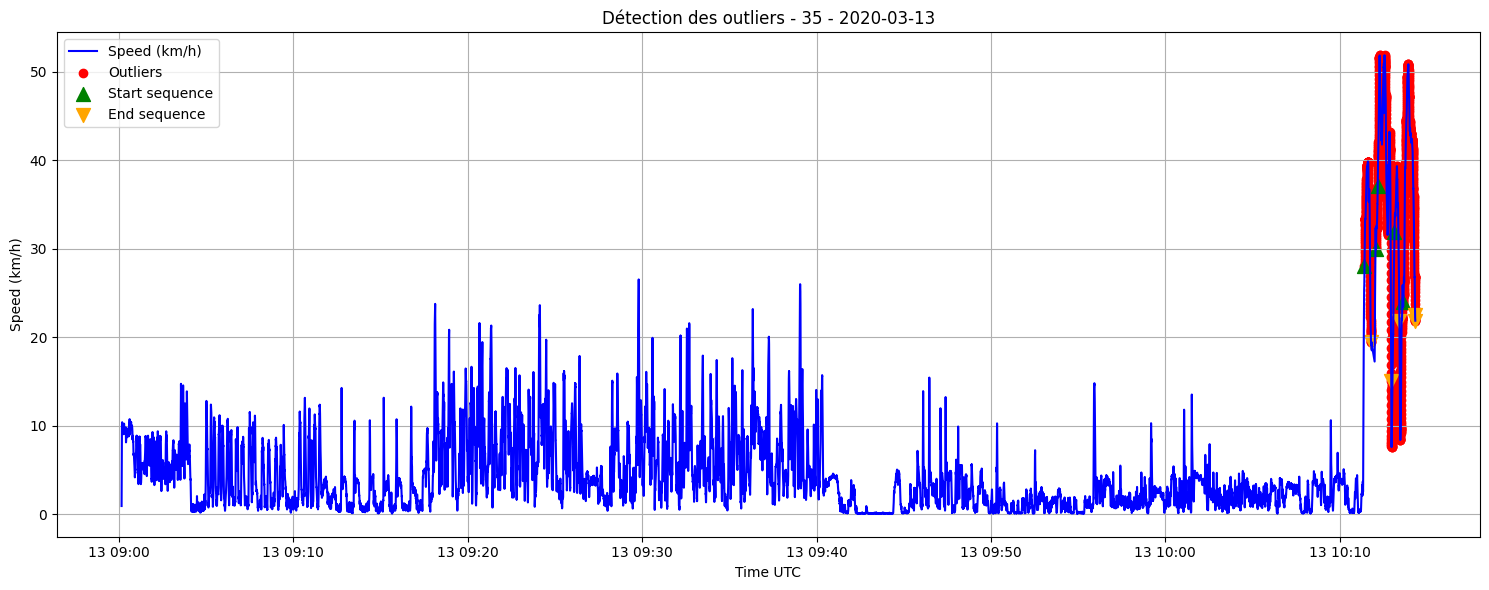

In [13]:

# === PARAMÈTRES DE FILTRAGE ===
player_to_plot = '35'       # Remplacer par le pseudo à visualiser
date_to_plot = '2020-03-13'      # Remplacer par la date à visualiser

# === RÉCUPÉRER LES DONNÉES DE LA SESSION ===
df_session = con.execute(f"""
SELECT t.player_pseudo, t.session_date, t.time_utc,
       t.x_pos, t.y_pos, t.speed_kmh,
       o.is_outlier_combined,
       o.outlier_start_combined,
       o.outlier_end_combined
FROM tracking_pseudo t
LEFT JOIN outliers_points o
  ON t.player_pseudo = o.player_pseudo
  AND t.session_date = o.session_date
  AND t.sensor_id = o.sensor_id
  AND t.time_utc = o.time_utc
WHERE t.player_pseudo = '{player_to_plot}'
  AND t.session_date = '{date_to_plot}'
ORDER BY t.time_utc
""").df()

# === PLOT POSITIONS ET OUTLIERS ===
plt.figure(figsize=(15,6))

# Courbe principale (position ou vitesse)
plt.plot(df_session['time_utc'], df_session['speed_kmh'], label='Speed (km/h)', color='blue')

# Points outliers
outliers = df_session[df_session['is_outlier_combined']]
plt.scatter(outliers['time_utc'], outliers['speed_kmh'], color='red', label='Outliers')

# Start / End des séquences
start_points = df_session[df_session['outlier_start_combined']]
end_points = df_session[df_session['outlier_end_combined']]

plt.scatter(start_points['time_utc'], start_points['speed_kmh'], 
            color='green', marker='^', s=100, label='Start sequence')
plt.scatter(end_points['time_utc'], end_points['speed_kmh'], 
            color='orange', marker='v', s=100, label='End sequence')

plt.title(f"Détection des outliers - {player_to_plot} - {date_to_plot}")
plt.xlabel("Time UTC")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# ============================================================================
# ÉTAPE 4 : CORRECTION PAR IMPUTATION PAR LA MOYENNE (TOUS LES JOUEURS)
# ============================================================================

# Récupérer toutes les sessions avec outliers détectés
sessions_to_correct = con.execute("""
SELECT DISTINCT 
    player_pseudo, 
    session_type,
    session_date, 
    sensor_id
FROM outliers_points
ORDER BY player_pseudo, session_type, session_date, sensor_id
""").df()

print(f"Nombre de sessions à corriger : {len(sessions_to_correct)}")


# ============================================================================
# CRÉER LA TABLE CORRIGÉE
# ============================================================================

con.execute("""
CREATE OR REPLACE TABLE tracking_corrected (
    player_pseudo BIGINT,
    session_type VARCHAR,
    session_date DATE,
    sensor_id INTEGER,
    time_utc TIMESTAMP,
    x_pos DOUBLE,
    y_pos DOUBLE,
    speed_kmh DOUBLE
)
""")


# ============================================================================
# BOUCLE SUR CHAQUE SESSION
# ============================================================================

for idx, session in sessions_to_correct.iterrows():
    player = session['player_pseudo']
    session_type = session['session_type']
    date = session['session_date']
    sensor = session['sensor_id']
    
    # Récupérer les données de la session avec marquage des outliers
    df_session = con.execute(f"""
    SELECT 
        t.player_pseudo, 
        t.session_type,
        t.session_date, 
        t.sensor_id, 
        t.time_utc,
        t.x_pos, 
        t.y_pos, 
        t.speed_kmh,
        o.is_outlier_combined
    FROM tracking_pseudo t
    LEFT JOIN outliers_points o
      ON t.player_pseudo = o.player_pseudo
      AND t.session_type = o.session_type
      AND t.session_date = o.session_date
      AND t.sensor_id = o.sensor_id
      AND t.time_utc = o.time_utc
    WHERE t.player_pseudo = '{player}'
      AND t.session_type = '{session_type}'
      AND t.session_date = '{date}'
      AND t.sensor_id = '{sensor}'
    ORDER BY t.time_utc
    """).df()
    
    # Remplacer les NULL (points non marqués) par False
    df_session['is_outlier_combined'] = df_session['is_outlier_combined'].fillna(False)

    # Calculer les moyennes sur les points valides (hors outliers)
    valid_points = df_session[~df_session['is_outlier_combined']]
    
    mean_speed = valid_points['speed_kmh'].mean()
    mean_x = valid_points['x_pos'].mean()
    mean_y = valid_points['y_pos'].mean()
    
    # Imputation par la moyenne
    df_session.loc[df_session['is_outlier_combined'], 'speed_kmh'] = mean_speed
    df_session.loc[df_session['is_outlier_combined'], 'x_pos'] = mean_x
    df_session.loc[df_session['is_outlier_combined'], 'y_pos'] = mean_y
    
    # Supprimer la colonne technique
    df_to_save = df_session.drop(columns=['is_outlier_combined'])
    
    # Insérer dans la table corrigée
    con.register('temp_corrected', df_to_save)
    con.execute("""
    INSERT INTO tracking_corrected 
    SELECT * FROM temp_corrected
    """)
    con.unregister('temp_corrected')
    
    print(f"[{idx+1}/{len(sessions_to_correct)}] {player} | {session_type} | {date} corrigée")


print("\n✅ Toutes les sessions ont été corrigées et stockées dans 'tracking_corrected'")


Nombre de sessions à corriger : 46
[1/46] 1 | practice | 2019-07-08 00:00:00 corrigée
[2/46] 1 | practice | 2020-03-13 00:00:00 corrigée
[3/46] 2 | game | 2020-12-12 00:00:00 corrigée
[4/46] 2 | practice | 2020-02-06 00:00:00 corrigée
[5/46] 2 | practice | 2020-03-13 00:00:00 corrigée
[6/46] 3 | practice | 2020-01-24 00:00:00 corrigée
[7/46] 6 | practice | 2019-09-28 00:00:00 corrigée
[8/46] 7 | practice | 2021-01-08 00:00:00 corrigée
[9/46] 8 | practice | 2020-11-04 00:00:00 corrigée
[10/46] 8 | practice | 2020-11-18 00:00:00 corrigée
[11/46] 13 | practice | 2019-07-11 00:00:00 corrigée
[12/46] 13 | practice | 2019-08-31 00:00:00 corrigée
[13/46] 13 | practice | 2020-02-04 00:00:00 corrigée
[14/46] 17 | practice | 2019-11-02 00:00:00 corrigée
[15/46] 17 | practice | 2020-02-06 00:00:00 corrigée
[16/46] 17 | practice | 2020-03-13 00:00:00 corrigée
[17/46] 18 | practice | 2019-09-18 00:00:00 corrigée
[18/46] 19 | practice | 2020-03-13 00:00:00 corrigée
[19/46] 19 | practice | 2020-11-04

In [15]:
#afficher session vitesse superieur a 45 km/h 
con.execute("""SELECT
    player_pseudo,
    session_date,
    sensor_id,
    time_utc,
    speed_kmh
FROM tracking_corrected
WHERE speed_kmh > 35
--- IGNORE ---
""").df()

,player_pseudo,session_date,sensor_id,time_utc,speed_kmh


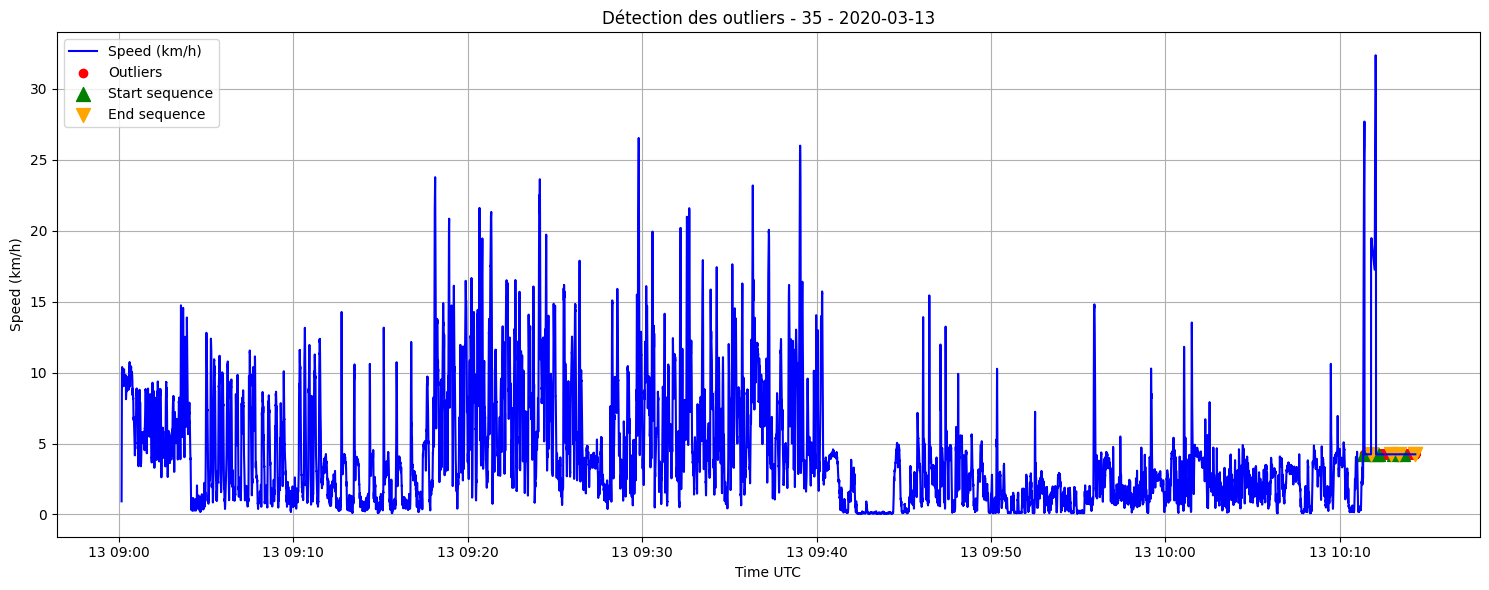

In [16]:

# === PARAMÈTRES DE FILTRAGE ===
player_to_plot = '35'       # Remplacer par le pseudo à visualiser
date_to_plot = '2020-03-13'      # Remplacer par la date à visualiser

# === RÉCUPÉRER LES DONNÉES DE LA SESSION ===
df_session = con.execute(f"""
SELECT t.player_pseudo, t.session_date, t.time_utc,
       t.x_pos, t.y_pos, t.speed_kmh,
       o.is_outlier_combined,
       o.outlier_start_combined,
       o.outlier_end_combined
FROM tracking_corrected t
LEFT JOIN outliers_points o
  ON t.player_pseudo = o.player_pseudo
  AND t.session_date = o.session_date
  AND t.sensor_id = o.sensor_id
  AND t.time_utc = o.time_utc
WHERE t.player_pseudo = '{player_to_plot}'
  AND t.session_date = '{date_to_plot}'
ORDER BY t.time_utc
""").df()

# === PLOT POSITIONS ET OUTLIERS ===
plt.figure(figsize=(15,6))

# Courbe principale (position ou vitesse)
plt.plot(df_session['time_utc'], df_session['speed_kmh'], label='Speed (km/h)', color='blue')

# Points outliers
outliers = df_session[df_session['is_outlier_combined']]
plt.scatter(outliers['time_utc'], outliers['speed_kmh'], color='red', label='Outliers')

# Start / End des séquences
start_points = df_session[df_session['outlier_start_combined']]
end_points = df_session[df_session['outlier_end_combined']]

plt.scatter(start_points['time_utc'], start_points['speed_kmh'], 
            color='green', marker='^', s=100, label='Start sequence')
plt.scatter(end_points['time_utc'], end_points['speed_kmh'], 
            color='orange', marker='v', s=100, label='End sequence')

plt.title(f"Détection des outliers - {player_to_plot} - {date_to_plot}")
plt.xlabel("Time UTC")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# ============================================================================
# ÉTAPE 5 : CRÉATION DE LA TABLE FINALE NETTOYÉE
# ============================================================================

con.execute("""
CREATE OR REPLACE TABLE tracking_clean AS

-- 1) Sessions corrigées
SELECT *
FROM tracking_corrected

UNION ALL

-- 2) Sessions sans outliers (donc jamais passées par l'étape 4)
SELECT 
    t.player_pseudo,
    t.session_type,
    t.session_date,
    t.sensor_id,
    t.time_utc,
    t.x_pos,
    t.y_pos,
    t.speed_kmh
FROM tracking_pseudo t

LEFT JOIN outliers_points o
  ON t.player_pseudo = o.player_pseudo
 AND t.session_type = o.session_type
 AND t.session_date = o.session_date
 AND t.sensor_id = o.sensor_id
 AND t.time_utc = o.time_utc

WHERE o.player_pseudo IS NULL
""")

print("✅ Table tracking_clean créée")


✅ Table tracking_clean créée


In [19]:
#fermer session duckdb
con.close()